In [21]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
import time

### Read data from csv...

In [2]:
raw_x = []
raw_y = []
# Reading CSV data...
with open("maize_major_yield.csv", 'r', newline='') as file:
    rows = csv.reader(file)
    header = next(rows)
    for row in rows:
        raw_x.append(row[:-1])
        raw_y.append(row[-1])
        
# Convert to numpy arrays...
raw_x = np.array(raw_x).astype(np.float64)
raw_y = np.array(raw_y).astype(np.float64)

## Data Processing...
### Removing un-natural temperature outliers...

In [3]:
temp_inds = [2,3,5,6,8,9,11,12,14,15,17,18,20,21,23,24,26,27,29,30,32,33,35,36]
rain_inds = [1,4,7,10,13,16,19,22,25,28,31,34]

# Removing outliers with temperature above the highest ever recorded WR (57 degrees Celsius)
upper_outliers = np.any(raw_x[:,temp_inds]>57, axis=1)
raw_y = np.delete(raw_y, upper_outliers, axis=0)
raw_x = np.delete(raw_x, upper_outliers, axis=0)

# Removing outliers with temperature below the lowest ever recorded WR (-95 degrees Celsius)
lower_outliers = np.any(raw_x[:,temp_inds]<-95, axis=1)
raw_y = np.delete(raw_y, lower_outliers, axis=0)
raw_x = np.delete(raw_x, lower_outliers, axis=0)

# Removing outliers with rainfall below 0mm...
rain_outliers = np.any(raw_x[:,rain_inds]<0, axis=1)
raw_y = np.delete(raw_y, rain_outliers, axis=0)
raw_x = np.delete(raw_x, rain_outliers, axis=0)

### Normalise and standardise functions...

In [4]:
def normalise_data(x_unnormalised):
    x_min = np.amin(x_unnormalised, axis=0)
    x_range = np.amax(x_unnormalised, axis=0) - x_min
    return (x_unnormalised - x_min) / x_range

def standardise_data(x_unstandardised):
    mean = np.mean(x_unstandardised, axis=0)
    std = x_unstandardised.std(axis=0)
    a = std
    b = mean
    x_standardised = (x_unstandardised / a) - (b / a)
    return x_standardised, a, b

# Standardisation checking function...
def stand_check(x_standardised, x_unstandardised, a, b):
    x_undo_stand = (a*x_standardised) + b
    return np.all(np.isclose(x_undo_stand, x_unstandardised))

### Standardisng, removing outliers above 10 std's from mean and then normalising...

In [5]:
# Standardising the dataset...
x_stand, m, std = standardise_data(raw_x)
# Testing standardisation...
print('Standardisation successful:', stand_check(x_stand, raw_x, m, std))

# Removing outliers 10 std's above mean...
print('x in:', x_stand.shape)
print('y in:', raw_y.shape)
def remove_outliers(x_matrix, y_matrix):
    find_outliers = np.all(np.abs(x_matrix) < 10, axis=1)
    return np.array(x_matrix[find_outliers]), np.array(y_matrix[find_outliers])

x_stand, raw_y = remove_outliers(x_stand, raw_y)

print('x out:', x_stand.shape)
print('y out:', raw_y.shape)

# Normalising data...
x_norm = normalise_data(x_stand)
print('Normalised')

Standardisation successful: True
x in: (31728, 37)
y in: (31728,)
x out: (31625, 37)
y out: (31625,)
Normalised


### Principle component analysis...

In [6]:
def PCA(x):
    covar_x = np.cov(x.T)
    # Find eigenvalues and eigenvectors...
    evals, evecs = np.linalg.eigh(covar_x)

    energy = np.cumsum(evals)
    count = 0
    while energy[count+1] < 0.03*energy[-1]:
        count += 1
    # Create rotation matrix...
    project = evecs[:, count:][:, ::-1].T
    # Apply rotation matrix to data...
    proj_x = project.dot(x.T).T
    print('New shape of X is', proj_x.shape)
    print('Kept {}% of total energy'.format(np.round(np.sum(evals[count:])*100/np.sum(evals), 3)))
    return proj_x

x = PCA(x_stand)

New shape of X is (31625, 16)
Kept 97.913% of total energy


### Splitting into Train, Test and Validation sets...
Here I will randomly shuffle the data and split this initailly into train and test sets with an 70:30 ratio, then split the test set into test and validation with a 50:50 ratio.

In [7]:
total_obs = x.shape[0]

# Randomly shuffling observations...
np.random.seed(4)
shuffle = np.random.permutation(total_obs)
x = x[shuffle]
y = raw_y[shuffle]

# Splitting off training set...
split = int(total_obs * 0.7)

train_x = x[:split]
train_y = y[:split]

test_val_x = x[split:]
test_val_y = y[split:]

# Splitting the rest into test and validation sets...
test_split = int(test_val_x.shape[0] * 0.5)

test_x = test_val_x[:test_split]
test_y = test_val_y[:test_split]

val_x = test_val_x[test_split:]
val_y = test_val_y[test_split:]

print('Training set size:', train_x.shape[0])
print('Test set size:', test_x.shape[0])
print('Validation set size:', val_x.shape[0])

Training set size: 22137
Test set size: 4744
Validation set size: 4744


## Gaussian Proccess Regression

### Vectorised kernel function...

In [8]:
def gp_kernel(X, length_scale, sigma_f, X2=None):
    '''
    Defining the radial basis function (squared exponential kernel) for a given length-scale and signal varaince (sigma_f)
    (VECTORISED)
    ========================================
    Input
    ========================================
    X: All observations (2D numpy array)
    length_scale: Alters spread of covariance - a hyper parameter
    sigma_f: Signal variance (variance in f(x)) - a hyper parameter
    
    ========================================
    Output
    ========================================
    Covariance matrix (2D numpy array)
    '''
    if X2 is None:
        if X.ndim == 1:
            X_norm = np.square(np.linalg.norm(X))
            distances = X_norm.reshape(-1, 1) + X_norm.reshape(1, -1) - 2*np.dot(X, X.T)
        else:
            X_norm = np.square(np.linalg.norm(X, axis=1))
            distances = X_norm.reshape(-1, 1) + X_norm.reshape(1, -1) - 2*np.dot(X, X.T)
    else:
        if X.ndim == 1:
            X1_norm = np.square(np.linalg.norm(X))
            X2_norm = np.square(np.linalg.norm(X2))
            distances = X1_norm.reshape(-1, 1) + X2_norm.reshape(1, -1) - 2*np.matmul(X.reshape(-1, 1), X2.reshape(1, -1))
        else:
            X1_norm = np.square(np.linalg.norm(X, axis=1))
            X2_norm = np.square(np.linalg.norm(X2, axis=1))
            distances = X1_norm.reshape(-1, 1) + X2_norm.reshape(1, -1) - 2*np.dot(X, X2.T)
    
    arg = distances / (2*(length_scale**2))
    return (sigma_f**2) * np.exp(-arg)

## The posterior

### Calculating posterior mean function (the predictions)...

In [22]:
def gp_alpha_inv(cov_X, sigma_e, n_train):
    I = np.identity(n_train)
    
    # Adding noise...
    alpha = cov_X + (sigma_e * I)
    
    # Using Cholesky decomposition to speed up matrix inversion...
    return scipy.linalg.cho_solve(sp.linalg.cho_factor(alpha), I)  # np.linalg.inv(alpha)

In [10]:
def gp_vect_predict(X, X_test, y_train, length_scale, sigma_f, sigma_e):
    
    # Calculating covaraince matrices...
    cov_X = gp_kernel(X, length_scale, sigma_f)
    cov_X_Xt = gp_kernel(X, length_scale, sigma_f, X2=X_test)
    
    # Calculating matrix inverse...
    n_train = X.shape[0]
    inv_alpha = gp_alpha_inv(cov_X, sigma_e, n_train)
    
    # Calculating mean function...
    inv_alpha_y = np.matmul(inv_alpha, y_train.reshape(n_train,1))
    return np.matmul(cov_X_Xt.T, inv_alpha_y).reshape(X_test.shape[0])

### Another function for the posterior distribution (outputs both mean and covariance for model uncertainty)...

In [11]:
def post_covars(X, X_test, length_scale, sigma_f):
    '''
    Generates posterior covariance matrices.
    ========================================
    Input
    ========================================
    X: Matrix of train observations
    X_test: Matrix of test observations
    length_scale: Alters spread of covariance - a hyper parameter
    sigma_f: Signal variance (variance in f(x)) - a hyper parameter
    
    ========================================
    Output
    ========================================
    Posterior covariance matrices (3 numpy arrays)
    '''
    cov_X = gp_kernel(X, length_scale, sigma_f)
    cov_X_Xt = gp_kernel(X, length_scale, sigma_f, X2=X_test)
    cov_Xt = gp_kernel(X_test, length_scale, sigma_f)
    return cov_X, cov_X_Xt, cov_Xt

In [12]:
def postior_mean(cov_X_Xt, cov_X, y_train, inv_alpha, sigma_e, n_train, n_test):
    inv_alpha_y = np.matmul(inv_alpha, y_train.reshape(n_train,1))
    return np.matmul(cov_X_Xt.T, inv_alpha_y).reshape(n_test)

In [13]:
def postior_covar(cov_Xt, cov_X_Xt, cov_X, inv_alpha, sigma_e, n_train):
    return cov_Xt - np.matmul(cov_X_Xt.T, np.matmul(inv_alpha, cov_X_Xt))

In [14]:
def post_dist(X, X_test, y_train, length_scale, sigma_f, sigma_e):
    
    # Calculating covariance matrices...
    covars = post_covars(X, X_test, length_scale, sigma_f)
    cov_X = covars[0]
    cov_X_Xt = covars[1]
    cov_Xt = covars[2]
    
    # Calculating posterior mean and covariance matrix...
    n_train = X.shape[0]
    n_test = X_test.shape[0]
    inv_alpha = gp_alpha_inv(cov_X, sigma_e, n_train)
    mean = postior_mean(cov_X_Xt, cov_X, y_train, inv_alpha, sigma_e, n_train, n_test)
    covar = postior_covar(cov_Xt, cov_X_Xt, cov_X, inv_alpha, sigma_e, n_train)
    
    # Returning the posterior distribution...
    return mean, covar

## Implementing GP on toy problem...

In [15]:
def performance(test_predicts, test_y):
    MAE = np.abs(test_y - test_predicts).mean()
    RMSE = np.sqrt(((test_y - test_predicts)**2).mean())
    R2 = 1 - (np.sum((test_y - test_predicts)**2) / np.sum((test_y - np.mean(test_y))**2))
    print('MAE =', MAE)
    print('RMSE =', RMSE)
    print('R-Squared =', R2)

In [24]:
# Generating features...
alpha = np.linspace(-2, 2, 1000)           # np.linspace(-4, 4, 500)
                                                      #beta = np.linspace(-10, 10, 500)**2
all_toy_y = 2*(alpha**2) + 0.5   # 2*np.sin(alpha) + 2                       # all_toy_y = 2*alpha - 1.5*beta + 0.25

# Standardising features...
all_toy_x = standardise_data(alpha)[0]

# Randomly shuffling observations...
#np.random.seed(2)
#shuffle = np.random.permutation(1000)
#all_toy_x = all_toy_x[shuffle]
#all_toy_y = all_toy_y[shuffle]

# Splitting into train and test sets...
# Train...
toy_x = all_toy_x[:850]
toy_y = all_toy_y[:850]
# Test...
toy_tst_x = all_toy_x[850:]
toy_tst_y = all_toy_y[850:]

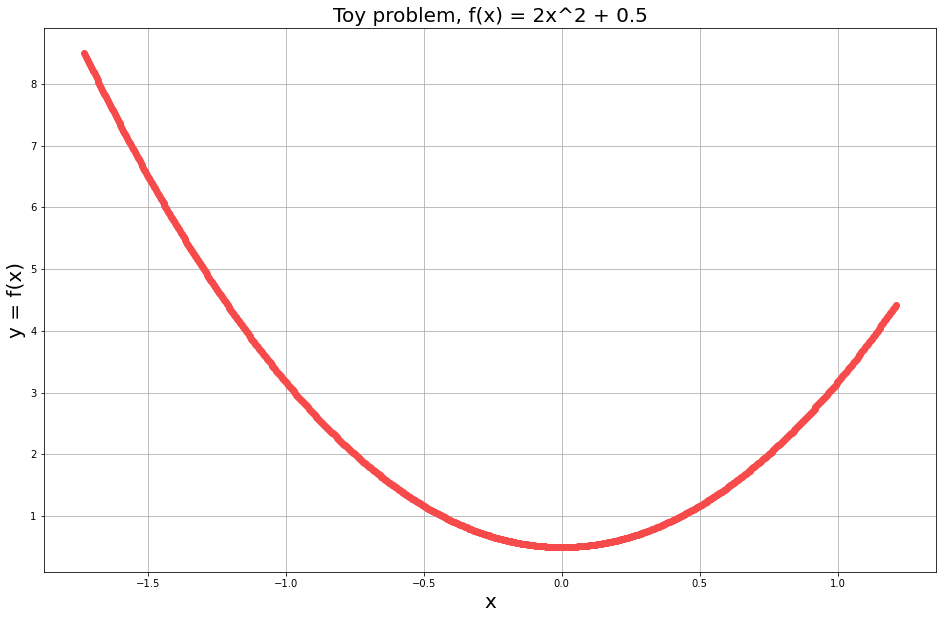

In [25]:
# Plotting a graph of toy problem...
plt.figure(figsize=(16,10))
plt.ylabel('y = f(x)', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.title('Toy problem, f(x) = 2x^2 + 0.5', fontsize=20)
plt.grid()
plt.plot(toy_x, toy_y, '#f74a4a', marker='o', linestyle='')
plt.show()

MAE = 0.005107845567845128
RMSE = 0.008230135459724945
R-Squared = 0.9999514649381933


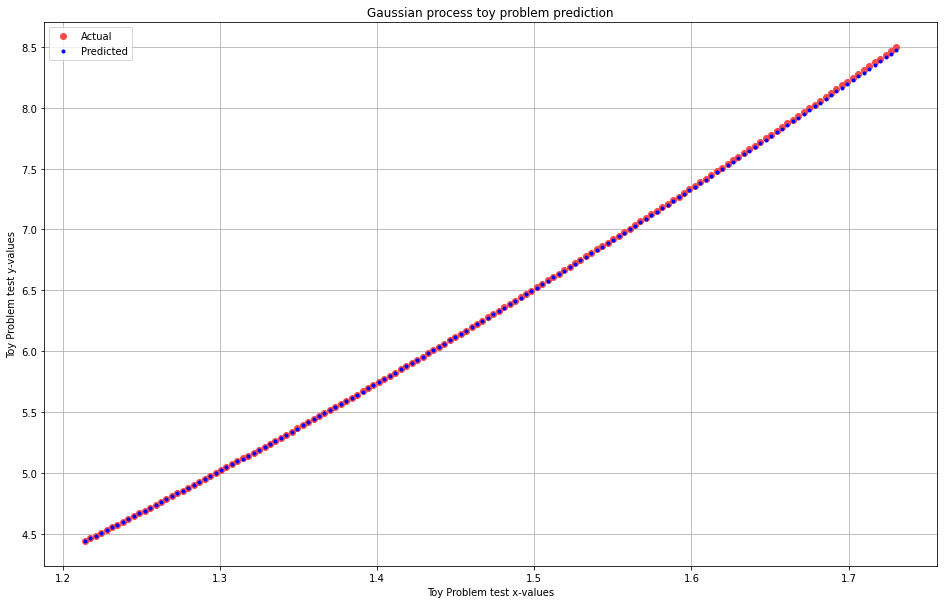

In [26]:
gp_preds = gp_vect_predict(toy_x.reshape(toy_x.shape[0],1), toy_tst_x.reshape(toy_tst_x.shape[0],1), toy_y, 1, 1, sigma_e=1e-10)

# Printing performance...
performance(gp_preds, toy_tst_y)

# Plotting graph of predicted vs true y-values...
plt.figure(figsize=(16,10))
plt.ylabel('Toy Problem test y-values')
plt.xlabel('Toy Problem test x-values')
plt.grid()
plt.plot(toy_tst_x, toy_tst_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_tst_x, gp_preds, 'b.', label='Predicted')
plt.legend()
plt.title('Gaussian process toy problem prediction')
plt.show()

## Another toy problem...

In [42]:
# Generating features...
n_obs = 1200

alpha = np.linspace(-2.5*np.pi, 2.5*np.pi, n_obs).reshape(n_obs,1)
beta = np.linspace(-2.5, 2.5, n_obs).reshape(n_obs,1)
x = np.hstack((alpha, beta))

y = 2*np.sin(alpha) + beta

# Standardising features...
x = standardise_data(x)[0]

# Randomly shuffling observations...
np.random.seed(2)
shuffle = np.random.permutation(800)
t_x = x[200:1000][shuffle]
t_y = y[200:1000][shuffle]

# Splitting into train and test sets...
# Train...
split = 700
toy_x = t_x[:split, :]
toy_y = t_y[:split]
# Test...
np.random.seed(3)
shuffle = np.random.permutation(np.arange(0,200))
toy_tst_x = np.vstack((np.vstack((t_x[split:, :], x[:200][shuffle][:50, :])), x[1000:][shuffle][:50, :]))
toy_tst_y = np.vstack((np.vstack((t_y[split:], y[:200][shuffle][:50])), y[1000:][shuffle][:50]))
toy_tst_y = toy_tst_y.reshape(toy_tst_y.shape[0])

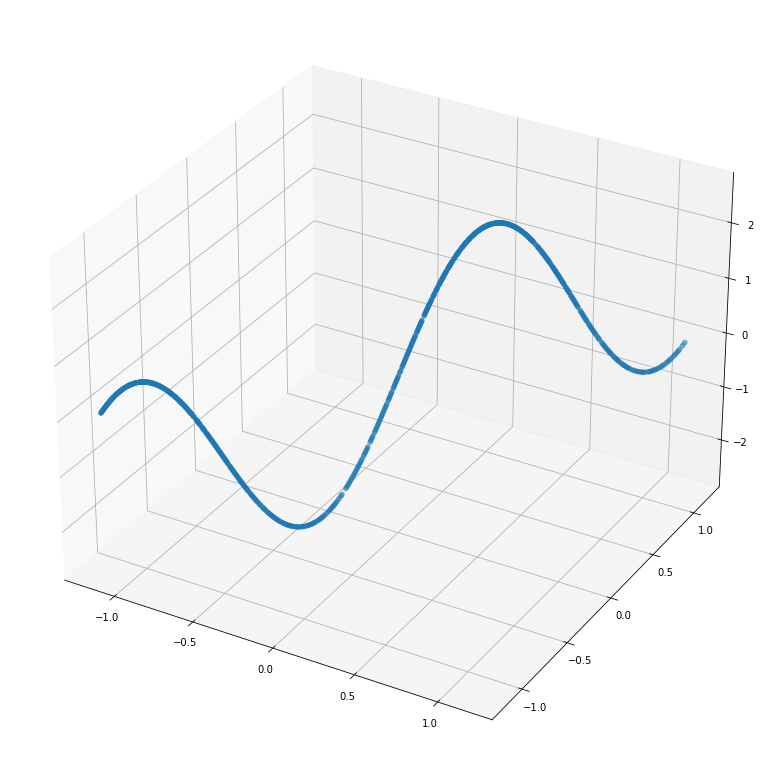

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_x[:,0].reshape(700), ys=toy_x[:,1].reshape(700), zs=toy_y)
plt.show()

Total time: 0 mins and 0.07 seconds
MAE = 0.0071704353714381166
RMSE = 0.01728107801261001
R-Squared = 0.9999442665525287


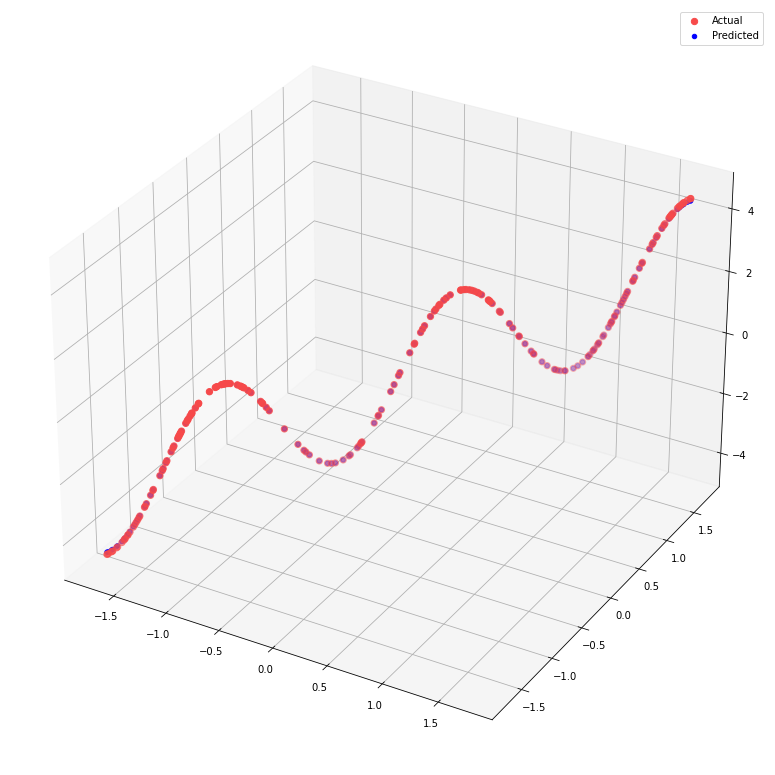

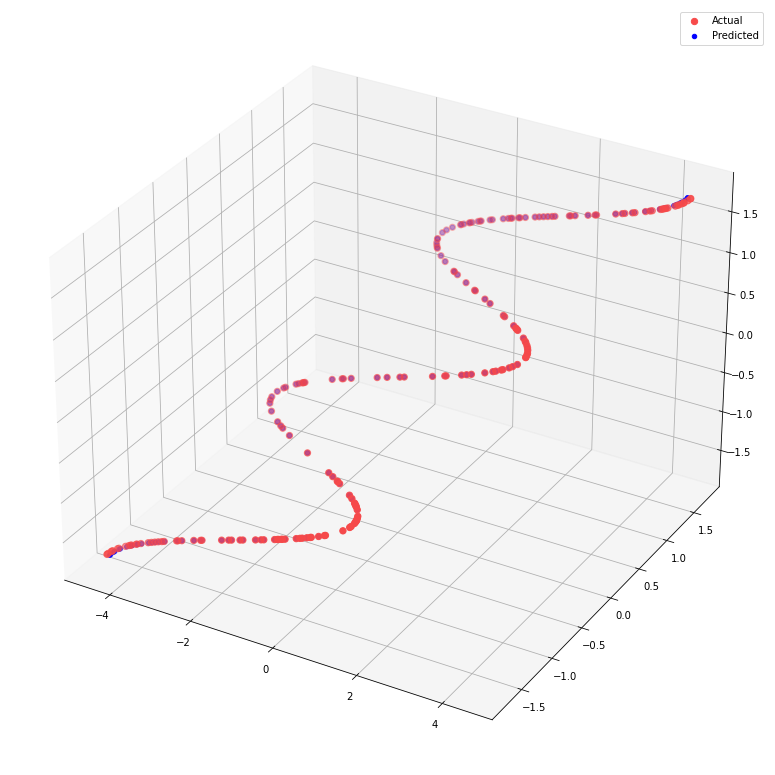

In [44]:
n_train = toy_x.shape[0]
t1 = time.time()
gp_preds = gp_vect_predict(toy_x, toy_tst_x, toy_y, 1, 1, sigma_e=1e-10)

# Printing time taken...
t3 = time.time()
delta_t3 = t3-t1
mins_3 = delta_t3//60
secs_3 = delta_t3 - (mins_3*60)
print('Total time: {} mins and {} seconds'.format(int(mins_3), round(secs_3, 2)))

# Printing performance...
performance(gp_preds, toy_tst_y)

# Plotting graph of predicted vs true y-values...
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(200), ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_y, c='#f74a4a', s=40, label='Actual')
ax.scatter(xs=toy_tst_x[:,0].reshape(200), ys=toy_tst_x[:,1].reshape(200), zs=gp_preds, c='b', label='Predicted')
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_y, ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_x[:,0].reshape(200), c='#f74a4a', s=40, label='Actual')
ax.scatter(xs=gp_preds, ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_x[:,0].reshape(200), c='b', label='Predicted')
plt.legend()
plt.show()

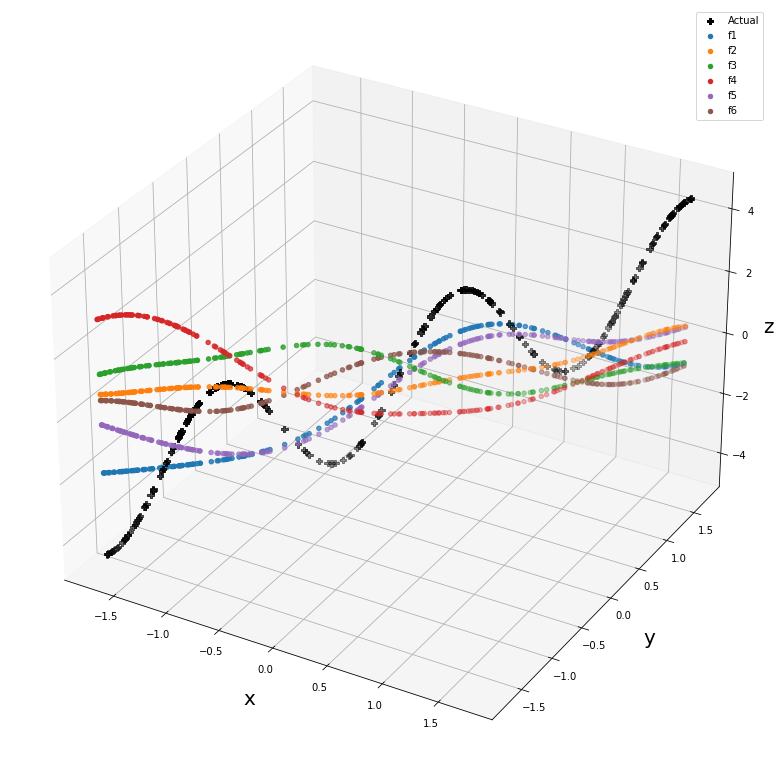

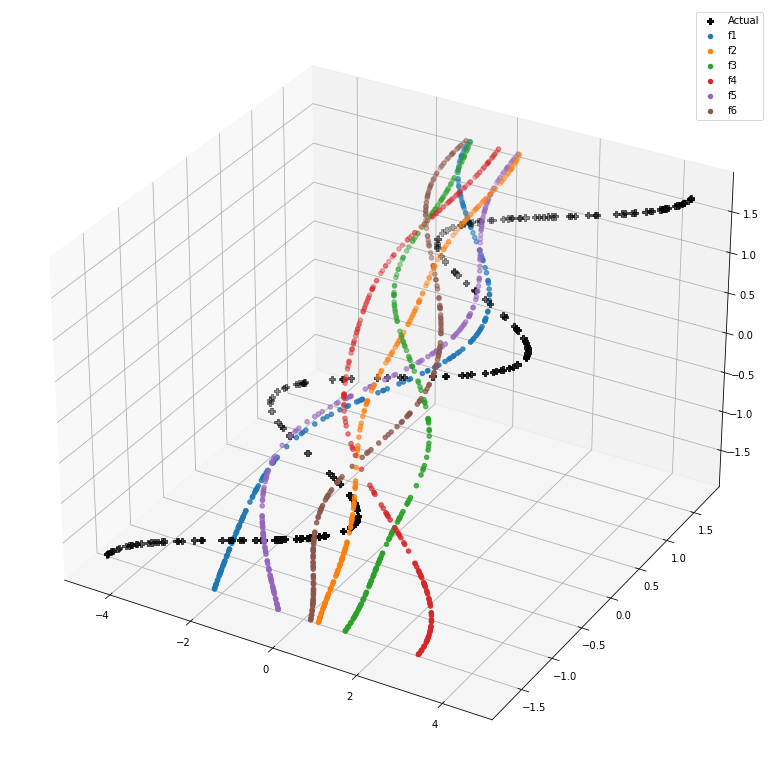

In [73]:
n_funcs = 6
n_obs = toy_tst_x.shape[0]

prior_mean = np.zeros(n_obs)
prior_cov = gp_kernel(toy_tst_x, 1, 1.05)

prior_y_samples = np.random.multivariate_normal(prior_mean, cov=prior_cov, size=n_funcs)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[0], label='f1')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[1], label='f2')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[2], label='f3')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[3], label='f4')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[4], label='f5')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[5], label='f6')
plt.xlabel('x', fontsize=20, labelpad=15)
plt.ylabel('y', fontsize=20, labelpad=15)
ax.set_zlabel('z', fontsize=20, labelpad=5)
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[0], label='f1')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[1], label='f2')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[2], label='f3')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[3], label='f4')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[4], label='f5')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[5], label='f6')
plt.legend()
plt.show()

<ipython-input-47-13d25e63b291>:8: RuntimeWarning: covariance is not positive-semidefinite.
  post_y_samples = np.random.multivariate_normal(postr_mean, cov=postr_cov, size=n_funcs)


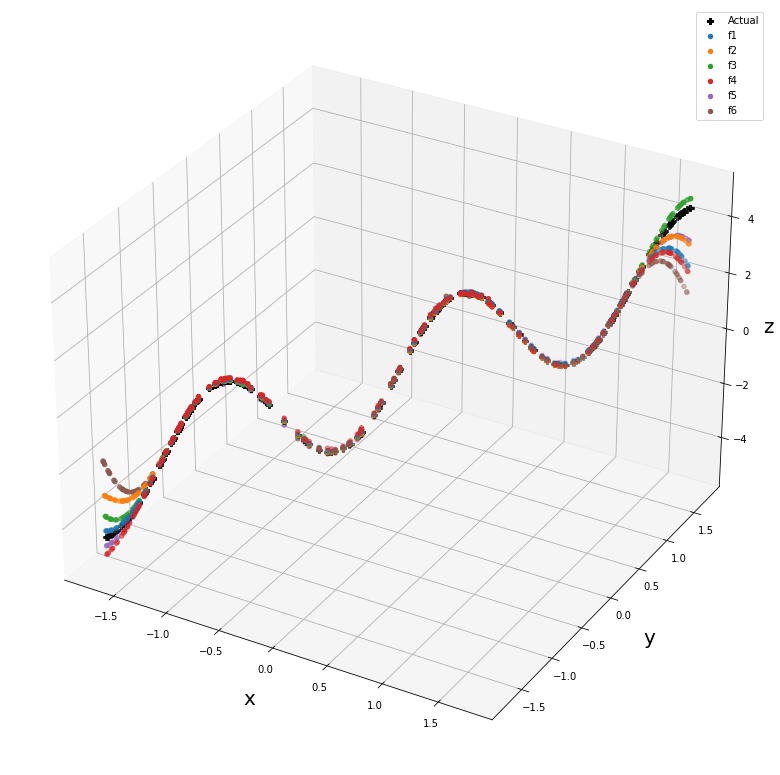

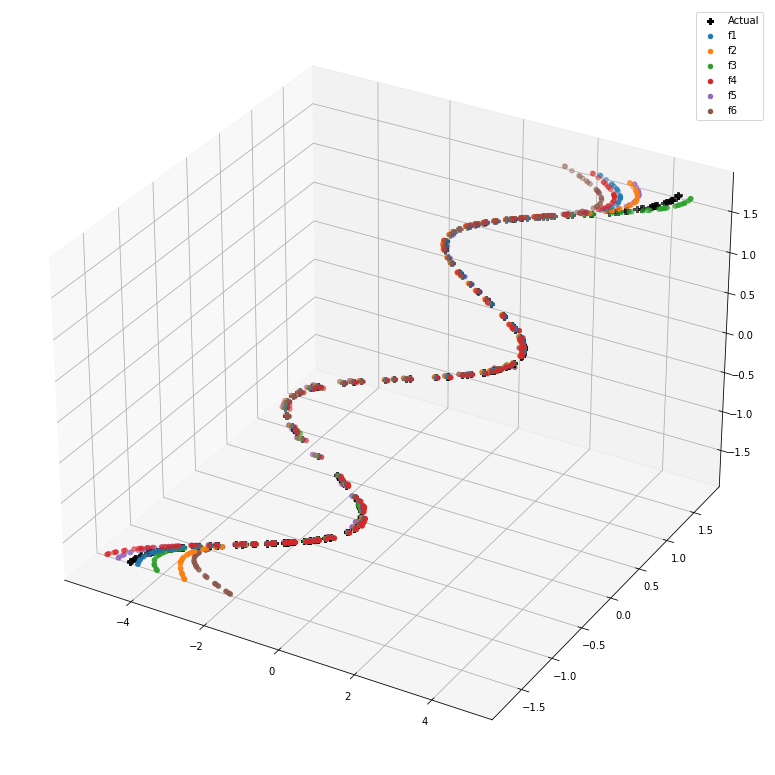

In [47]:
n_funcs = 6
n_obs = toy_tst_x.shape[0]

posterior_distribution = post_dist(toy_x, toy_tst_x, toy_y, length_scale=0.4, sigma_f=2.5, sigma_e=1e-10)
postr_mean = posterior_distribution[0]
postr_cov = posterior_distribution[1]

post_y_samples = np.random.multivariate_normal(postr_mean, cov=postr_cov, size=n_funcs)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[0], label='f1')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[1], label='f2')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[2], label='f3')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[3], label='f4')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[4], label='f5')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[5], label='f6')
plt.xlabel('x', fontsize=20, labelpad=15)
plt.ylabel('y', fontsize=20, labelpad=15)
ax.set_zlabel('z', fontsize=20, labelpad=5)
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[0], label='f1')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[1], label='f2')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[2], label='f3')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[3], label='f4')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[4], label='f5')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[5], label='f6')
plt.legend()
plt.show()

## Implementing GP to predict crop yield
### Using sample of 8000 observations to train...

In [70]:
# Generating sub-sample of observations...
# Train observations
np.random.seed(1)
train_shuffle = np.random.randint(0, train_x.shape[0], size=8000)
train_x_sample = train_x[train_shuffle]
train_y_sample = train_y[train_shuffle]

# Test observations
np.random.seed(2)
test_shuffle = np.random.randint(0, test_x.shape[0], size=3000)
test_x_sample = test_x[test_shuffle]
test_y_sample = test_y[test_shuffle]

# Validation observations
np.random.seed(1)
val_shuffle = np.random.randint(0, val_x.shape[0], size=2000)
val_x_sample = val_x[val_shuffle]
val_y_sample = val_y[val_shuffle]

In [71]:
# Optimal Hyperparameters...
length_scale = 2.4
sigma_f = 3.2
sigma_e = 1.83

# Predicting yield values...
t1 = time.time()
gp_predictions = gp_vect_predict(train_x_sample, val_x_sample, train_y_sample, length_scale, sigma_f, sigma_e)
t2 = time.time()

# Printing time taken...
delta_t1 = t2-t1
mins_1 = delta_t1//60
secs_1 = delta_t1 - (mins_1*60)
print('Total time: {} mins and {} seconds'.format(int(mins_1), round(secs_1, 2)))

# Printing performance...
performance(gp_predictions, val_y_sample)

Total time: 0 mins and 14.76 seconds
MAE = 1.452033511664555
RMSE = 2.173325943580862
R-Squared = 0.6388777745420245


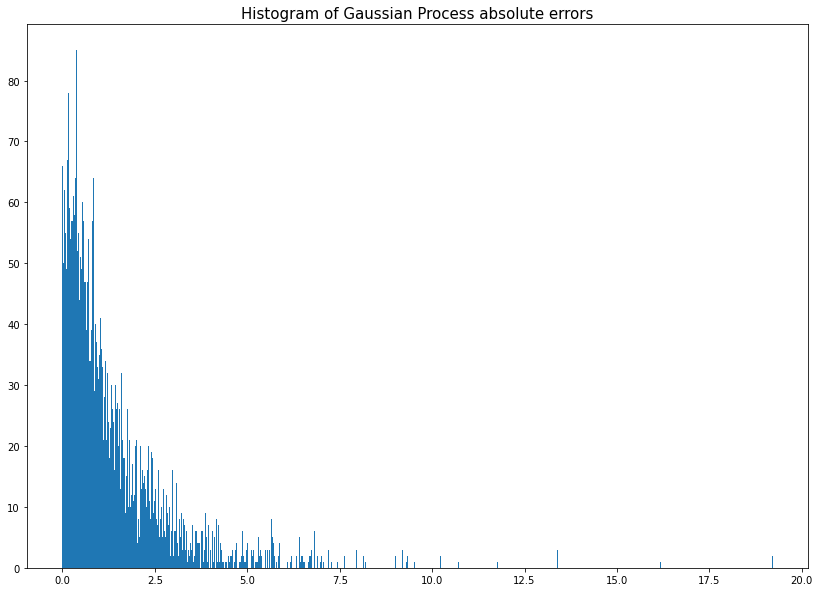

In [65]:
AE = np.abs(gp_predictions - val_y_sample)
plt.figure(figsize=(14,10))
plt.hist(AE, bins=1000)
plt.title('Histogram of Gaussian Process absolute errors', fontsize=15)
plt.show()

### Tuning GP hyperparameters...

In [357]:
def tune_gp_rand(val_x, val_y, train_x, train_y, num_iters=10):
    best = {'RMSE' : np.inf}
    
    # Random Hyperparameter generation...
    l = np.random.rand(num_iters)*4.5 + 0.5
    sigma_f = np.linspace(0.5, 5, num_iters)
    sigma_e = np.linspace(0.3, 4, num_iters)
    
    rmse_list = []
    mae_list = []
    r2_list = []
    n_train = train_x.shape[0]
    for i in range(num_iters):
        print('\nIteration number:', i+1)
        print('l = {}, sigma_f = {}, sigma_e = {}'.format(l[i], sigma_f[i], sigma_e[i]))
        
        # Predicting yields...
        t1 = time.time()
        val_predicts = gp_vect_predict(train_x, val_x, train_y, l[i], sigma_f[i], sigma_e[i])
        t2 = time.time()
        
        # Printing time taken...
        delta_t1 = t2-t1
        mins_1 = delta_t1//60
        secs_1 = delta_t1 - (mins_1*60)
        print('Prediction took {} mins and {} seconds'.format(int(mins_1), round(secs_1, 2)))
        
        RMSE = np.sqrt(((val_y - val_predicts)**2).mean())
        rmse_list.append(RMSE)
        MAE = np.abs(val_y - val_predicts).mean()
        mae_list.append(MAE)
        R2 = 1 - (np.sum((val_y - val_predicts)**2) / np.sum((val_y - np.mean(val_y))**2))
        r2_list.append(R2)
        print('MAE =', MAE)
        print('RMSE =', RMSE)
        print('R-Squared =', R2)
        
        if RMSE < best['RMSE']:
            best = {'RMSE' : RMSE, 'l' : l[i], 'sigma_f' : sigma_f[i], 'sigma_e' : sigma_e[i]}
            print('New best:', best)
    
    return best, rmse_list, l, sigma_f, sigma_e

In [358]:
print('{} Train observations, {} Validation observations'.format(sample_y.shape[0], val_y_sample.shape[0]))
t1 = time.time()
tuned = tune_gp_rand(val_x_sample, val_y_sample, sample_x, sample_y, num_iters=70)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('\n{} mins and {} seconds'.format(mins, secs))

best = tuned[0]
print('\nOverall best is...', best)

rmse_list = tuned[1]
#l_list = tuned[2]
#sigma_f_list = tuned[3]
sigma_e_list = tuned[4]

4990 Train observations, 2000 Validation observations

Iteration number: 1
l = 2.4, sigma_f = 2.98, sigma_e = 0.3
Prediction took 0 mins and 4.19 seconds
MAE = 1.494886363225023
RMSE = 2.2697276443396643
R-Squared = 0.6061308335842379
New best: {'RMSE': 2.2697276443396643, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.3}

Iteration number: 2
l = 2.4, sigma_f = 2.98, sigma_e = 0.372463768115942
Prediction took 0 mins and 4.29 seconds
MAE = 1.4860932821860544
RMSE = 2.2550511947708034
R-Squared = 0.611208017000215
New best: {'RMSE': 2.2550511947708034, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.372463768115942}

Iteration number: 3
l = 2.4, sigma_f = 2.98, sigma_e = 0.4449275362318841
Prediction took 0 mins and 4.17 seconds
MAE = 1.4805182660179843
RMSE = 2.2446959499063053
R-Squared = 0.6147705014095395
New best: {'RMSE': 2.2446959499063053, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.4449275362318841}

Iteration number: 4
l = 2.4, sigma_f = 2.98, sigma_e = 0.5173913043478261
Prediction took 0 mins 

Prediction took 0 mins and 4.25 seconds
MAE = 1.4702745888621598
RMSE = 2.208665576779005
R-Squared = 0.6270381464684812

Iteration number: 32
l = 2.4, sigma_f = 2.98, sigma_e = 2.546376811594203
Prediction took 0 mins and 3.98 seconds
MAE = 1.4706250187719105
RMSE = 2.2089359708951584
R-Squared = 0.6269468217655993

Iteration number: 33
l = 2.4, sigma_f = 2.98, sigma_e = 2.618840579710145
Prediction took 0 mins and 3.96 seconds
MAE = 1.4709807262912598
RMSE = 2.2092252293431662
R-Squared = 0.6268491133212913

Iteration number: 34
l = 2.4, sigma_f = 2.98, sigma_e = 2.6913043478260867
Prediction took 0 mins and 3.87 seconds
MAE = 1.4713586284844455
RMSE = 2.2095316530814575
R-Squared = 0.6267455926681045

Iteration number: 35
l = 2.4, sigma_f = 2.98, sigma_e = 2.763768115942029
Prediction took 0 mins and 4.0 seconds
MAE = 1.4717444759691334
RMSE = 2.2098537211443903
R-Squared = 0.6266367713392832

Iteration number: 36
l = 2.4, sigma_f = 2.98, sigma_e = 2.836231884057971
Prediction took 

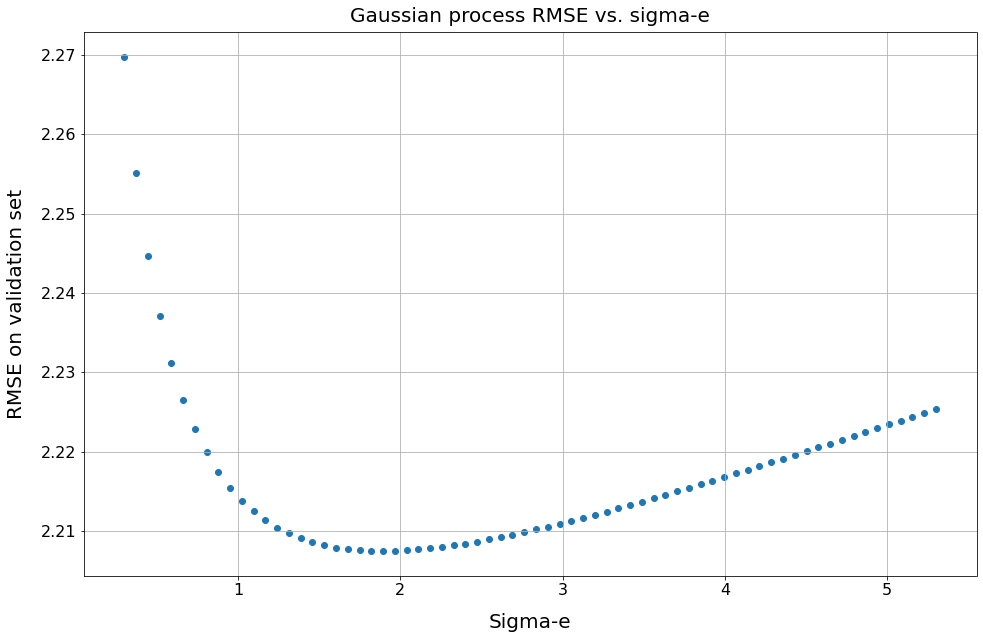

In [359]:
fig = plt.figure(figsize=(16,10))
plt.ylabel('RMSE on validation set', fontsize=20, labelpad=15)
plt.xlabel('Sigma-e', fontsize=20, labelpad=15)
plt.title('Gaussian process RMSE vs. sigma-e', fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.scatter(sigma_e_list, rmse_list)
plt.show()